In [57]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [58]:
import numpy as np
import pandas as pd

In [59]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [60]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [61]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", connect_args={'check_same_thread':False})
conn = engine.connect()

In [62]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [63]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [64]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [65]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

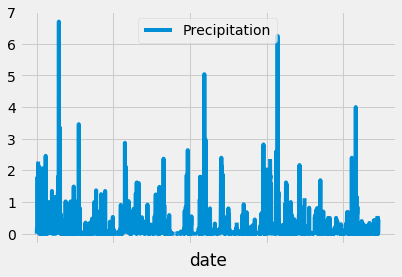

In [66]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).first()[0]
year_date = str((dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)).date())


# Perform a query to retrieve the data and precipitation scores
query_yr = session.query(Measurement.date, Measurement.prcp).\
            order_by(Measurement.date).\
            filter(Measurement.date >= year_date)


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(query_yr.statement, conn, index_col='date')

# Sort the dataframe by date
df = df.sort_index()
df = df.rename(columns={'prcp':'Precipitation'})

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)


In [67]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [68]:
# Design a query to show how many stations are available in this dataset?
AvailableStations = session.query(Measurement.station).group_by(Measurement.station).count()
AvailableStations

9

In [69]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
ActiveStations = session.query(Measurement.station, func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.date).desc()).all()
ActiveStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [70]:
# The station with the most observations is the first on the list:
MostActive = ActiveStations[0][0]
MostActive

'USC00519281'

In [71]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

MostActiveStats = session.query(func.min(Measurement.tobs), 
                                func.max(Measurement.tobs),
                                func.avg(Measurement.tobs)).\
                                filter_by(station=MostActive).all()
MostActiveStats

[(54.0, 85.0, 71.66378066378067)]

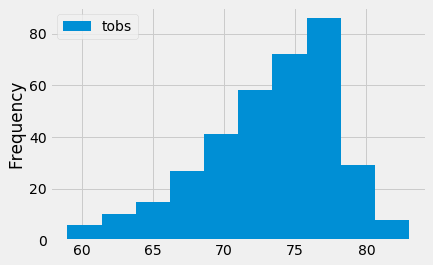

In [72]:
# Choose the station with the highest number of temperature observations.

# Need to count again in case there are null values in the tobs column:
StationMostT = session.query(Measurement.station, func.count(Measurement.tobs)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.date).desc()).all()[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

t = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_date, Measurement.station==StationMostT)

t_df = pd.read_sql(t.statement, conn)

t_df.plot(kind='hist')

In [73]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [74]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
StartDate = '2019-04-15'
EndDate = '2019-04-25'

# Since the last date in the dataset is in 2017, selection was done 2yr back:
PreviousStart = '2017-04-15'
PreviousEnd = '2017-04-25'
tstats = calc_temps(PreviousStart, PreviousEnd)
print(tstats)

[(67.0, 73.44117647058823, 83.0)]


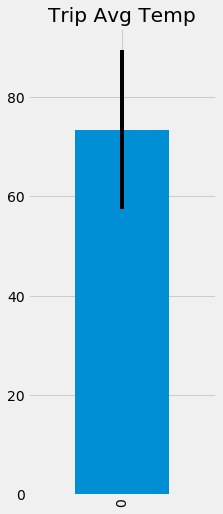

In [75]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tstats_df = pd.DataFrame(tstats, columns=['min', 'avg', 'max'])

tstats_df['avg'].plot(kind='bar',
                      yerr = tstats_df['max']-tstats_df['min'],
                      title = "Trip Avg Temp", 
                      figsize=(3,8)
                     )
plt.show()


In [76]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Station.station, 
                         Station.name, 
                         Station.latitude, 
                         Station.longitude, 
                         Station.elevation,
                         func.sum(Measurement.prcp)).\
                        filter(Measurement.station == Station.station).\
                        filter(Measurement.date >= PreviousStart, Measurement.date <= PreviousEnd).\
                        group_by(Measurement.station).\
                        order_by(func.sum(Measurement.prcp).desc()).\
                        all()


rainfall

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  7.379999999999999),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.0200000000000005),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 3.97),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  3.1599999999999997),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.8699999999999999),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.68),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [77]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [78]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip 
start = dt.datetime.strptime(StartDate, "%Y-%m-%d").date()
end = dt.datetime.strptime(EndDate, "%Y-%m-%d").date()

# Use the start and end date to create a range of dates
date_range = [start + dt.timedelta(days=i) for i in range((end-start).days+1)]

# Stip off the year and save a list of %m-%d strings
date_list = [i.strftime("%m-%d") for i in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(i)[0] for i in date_list]
normals

[(61.0, 71.79310344827586, 79.0),
 (62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0),
 (65.0, 73.01818181818182, 79.0),
 (67.0, 73.3103448275862, 80.0),
 (66.0, 73.96551724137932, 83.0)]

In [79]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=date_range)
normals_df

,tmin,tavg,tmax
2019-04-15,61.0,71.793103,79.0
2019-04-16,62.0,71.553571,81.0
2019-04-17,65.0,71.931034,77.0
2019-04-18,67.0,72.491525,77.0
2019-04-19,65.0,72.421053,83.0
2019-04-20,64.0,72.736842,80.0
2019-04-21,66.0,72.321429,78.0
2019-04-22,65.0,72.927273,84.0
2019-04-23,65.0,73.018182,79.0
2019-04-24,67.0,73.310345,80.0


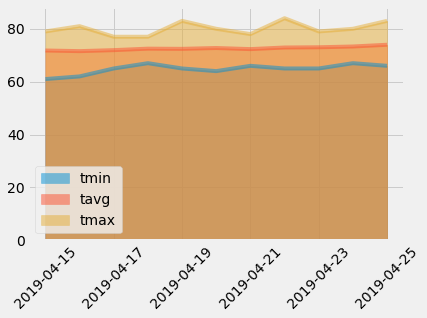

In [82]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, rot=45)